# Buildings
This notebook calculates the ETLocal keys of the Buildings section. 

## Setup

### Parameters

In [1]:
# ───────── LIBRARIES ─────────
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import importlib


# Import
import src.load_data_manager
import src.transform
import src.yaml_calculator
import src.helper
from src.load_data_manager import LoadDataManager
import config.yaml_to_diagram
from config.yaml_to_diagram import create_dependency_diagram

# Reload
importlib.reload(src.transform)
importlib.reload(src.yaml_calculator)
importlib.reload(src.helper)
importlib.reload(src.load_data_manager)
importlib.reload(config.yaml_to_diagram)

<module 'config.yaml_to_diagram' from '/Users/koenvanbemmelen/work/etdataset/pipelines/config/yaml_to_diagram.py'>

## General

### Parameters


We first specify general parameters to be used throughout this notebook.

In [2]:
# General parameters
parent = "nl"
year = 2023
year_etm = 2019
sep = ","

# Paths
dep_graph_folder = Path("config", "etlocal_keys_final_demand_dependency_outputs", "output")
yaml_folder = Path("config", "yaml_files_for_etlocal_key_calculation")
fillup_data_folder = Path("data", "fill_up_data")

## Extract and Transform

In this section:
- We *Load* the relevant data from the data/intermediate folder
- We *Combine* the relevant data by merging municipal and national data

This is handled by the **ETLocalDataModule** which provides a unified interface for all data operations.

The module loads the following data sources:
- The ETLocal template (ETLocal_template_empty.csv)
- Klimaatmonitor data - both municipal and national levels with metadata:
  - km_source_data_converted.csv (municipal data)
  - km_meta_data_converted.csv (municipal metadata)
  - km_national_source_data_converted.csv (national data)
  - km_national_meta_data_converted.csv (national metadata)
- Transport research data (transport_research_cleaned.csv)
- Miscellaneous data (miscellaneous_data_analysis.csv)
- ETM query results (etm_query_combined.csv)

The module:
- Combines municipal-level data from different sources
- Combines national-level data from different sources
- Merges the municipal and national datasets into a single DataFrame
- Caches loaded data for improved performance

In [3]:
# Initialize the data manager
data_manager = LoadDataManager(sep=sep)

# Load template filtered for buildings
df_template_local = data_manager.load_template(group='buildings')

# Load and combine all data sources
df_input_vars = data_manager.combine_all_data(
    include_miscellaneous=True,
    include_etm_queries=True
)

# Load old variables from combined dataset
data_dict = data_manager.load_all_data()
df_ivar_eq_data = data_dict['etm_queries']
df_ivar_nl_data = data_dict['km_nl_data']
df_ivar_tr_data = data_dict['transport']

print(f"Template shape: {df_template_local.shape}")
print(f"Combined data shape: {df_input_vars.shape}")
print(f"Available municipalities: {len(df_input_vars)}")

Template shape: (16416, 3)
Combined data shape: (342, 1883)
Available municipalities: 342


In [4]:
df_input_vars

,Gemeentenaam,ProvinciecodePV,Provincienaam,no_inhabitants,no_residences,no_cars,total_energy_tj,tp_total_energy_tj,total_electricity_tj,total_gas_heat_tj_temp_corrected,...,mq_buildings_final_demand_for_lighting_electricity_buildings_lighting_led_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_airconditioning_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_heatpump_air_water_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_collective_heatpump_water_water_ts_electricity_parent_share,mq_input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water,mq_input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water,mq_input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water
GM0014,Groningen,PV20,Groningen,238147,122715,NaN,15294,4045,3218,8031,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0034,Almere,PV24,Flevoland,222825,90690,NaN,10680,3869,2654,4289,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0037,Stadskanaal,PV20,Groningen,32135,15177,NaN,1759,534,409,815,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0047,Veendam,PV20,Groningen,27616,13013,NaN,0,580,786,0,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0050,Zeewolde,PV24,Flevoland,23692,9354,NaN,3139,1581,765,794,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1979,Eemsdelta,PV20,Groningen,45394,23587,NaN,0,1049,2026,0,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1980,Dijk en Waard,PV27,Noord-Holland,88985,37459,NaN,5168,1350,1110,2708,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1982,Land van Cuijk,PV30,Noord-Brabant,91423,39868,NaN,9022,3179,2073,3769,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1991,Maashorst,PV30,Noord-Brabant,58934,26012,NaN,4607,1761,1191,1655,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0


#### Electric cars distribution

These are the allocation keys for the share of gasoline/electric car consumption per municipality, as a share of total national consumption in the Netherlands.

To generate this file, the Transport Jupyter Notebook must be run first; otherwise, the CSV will not be available.

TO DO: add the calculation of these shares to the preprocessing notebook and append it to the km_source_data_converted dataframe.

In [5]:
path_electric_cars_shares = Path("data", "intermediate", f"shares_cars_road_transport_gasoline_electricity.csv")
electric_cars_shares = pd.read_csv(path_electric_cars_shares, sep=',', index_col=0)
electric_cars_shares.rename(columns={'final_demand_road_gasoline_tj_share_NL': 'electric_cars_distribution'}, inplace=True)

electric_cars_shares

,electric_cars_distribution
GemeenteCode,
GM1680,0.002748
GM0358,0.001294
GM0197,0.001025
GM0059,0.001280
GM0482,0.001005
...,...
GM0879,0.000963
GM0301,0.001585
GM1896,0.001020


We append this data as a column to `combined_data` so that the YAML calculator has access to it.

In [6]:
# append electric cars shares to the combined data
df_input_vars = df_input_vars.join(electric_cars_shares, how='left')


## Energy demand

##### Gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

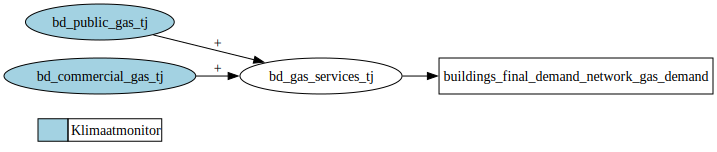

In [7]:
# Define ETLocal key
etlocal_key = "buildings_final_demand_network_gas_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [8]:
def CommitMessage(output_description,arithmic,vars_description,sector,year,vars_source):
    if len(vars_description) == 2:
        return f"{output_description} in the {sector} sector is calculated by {arithmic}ing {vars_description[0]} ({vars_source[0]}, {year}) by the {vars_description[1]} ({vars_source[1]}, {year})."
    elif len(vars_description) == 3:
        return "Left to be written"
    elif len(vars_description) == 1:
        return "Left to be written"
    elif len(vars_description) == 4:
        return f"{output_description} in the {sector} sector is calculated by {arithmic[0]}ing {vars_description[0]} ({vars_source[0]}, {year}), {vars_description[1]} ({vars_source[1]}, {year}), {vars_description[2]} ({vars_source[2]}, {year}), and {arithmic[3]} {vars_description[3]} ({vars_source[3]}, {year})."
    else:
        return "Left to be written"

Read the information for the commit message from the image and write them down to generate the commit message.

In [9]:
sector = 'buildings'
output_description = 'Final gas demand'
arithmic_op= 'add'
vars_description = ['total gas demand in public buildings', 'total gas demand in commercial buildings']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']


message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final gas demand in the buildings sector is calculated by adding total gas demand in public buildings (Klimaatmonitor, 2023) by the total gas demand in commercial buildings (Klimaatmonitor, 2023).


2. Calculate etlocal_key values

In [10]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,buildings_final_demand_network_gas_demand,bd_gas_services_tj,error_message,commit
GM0014,1574.290212,1574.290212,NaN,Final gas demand in the buildings sector is ca...
GM0034,244.512771,244.512771,NaN,Final gas demand in the buildings sector is ca...
GM0037,147.978341,147.978341,NaN,Final gas demand in the buildings sector is ca...
GM0047,142.571919,142.571919,NaN,Final gas demand in the buildings sector is ca...
GM0050,188.402354,188.402354,NaN,Final gas demand in the buildings sector is ca...
...,...,...,...,...
GM1979,277.920296,277.920296,NaN,Final gas demand in the buildings sector is ca...
GM1980,229.665123,229.665123,NaN,Final gas demand in the buildings sector is ca...
GM1982,408.633150,408.633150,NaN,Final gas demand in the buildings sector is ca...
GM1991,340.870500,340.870500,NaN,Final gas demand in the buildings sector is ca...


3. Add data to template

In [11]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_energy_demand,TJ,1574.290212,Final gas demand in the buildings sector is ca...
GM0034,buildings,buildings_energy_demand,TJ,244.512771,Final gas demand in the buildings sector is ca...
GM0037,buildings,buildings_energy_demand,TJ,147.978341,Final gas demand in the buildings sector is ca...
GM0047,buildings,buildings_energy_demand,TJ,142.571919,Final gas demand in the buildings sector is ca...
GM0050,buildings,buildings_energy_demand,TJ,188.402354,Final gas demand in the buildings sector is ca...
...,...,...,...,...,...
GM1979,buildings,buildings_energy_demand,TJ,277.920296,Final gas demand in the buildings sector is ca...
GM1980,buildings,buildings_energy_demand,TJ,229.665123,Final gas demand in the buildings sector is ca...
GM1982,buildings,buildings_energy_demand,TJ,408.633150,Final gas demand in the buildings sector is ca...


4. Use validation function to quick-scan data.

In [12]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'buildings_final_demand_network_gas_demand',
 'total_rows': 342,
 'zero_count': 1,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 5777.38429,
 'mean_value': 256.6479750580409,
 'median_value': 143.037459125}

In [13]:
verification_results = src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: buildings_final_demand_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 331 municipalities (97.9%)
  medium_diff: 5 municipalities (1.5%)
  small_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=5777.38, Mean=256.03
  Verification: Min=10.68, Max=8762.76, Mean=381.46
  Abs diff:     Min=0.13, Max=8610.60, Mean=125.97

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1911: Template=152.17, Verification=8762.76, Diff=8610.6

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Biomass demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

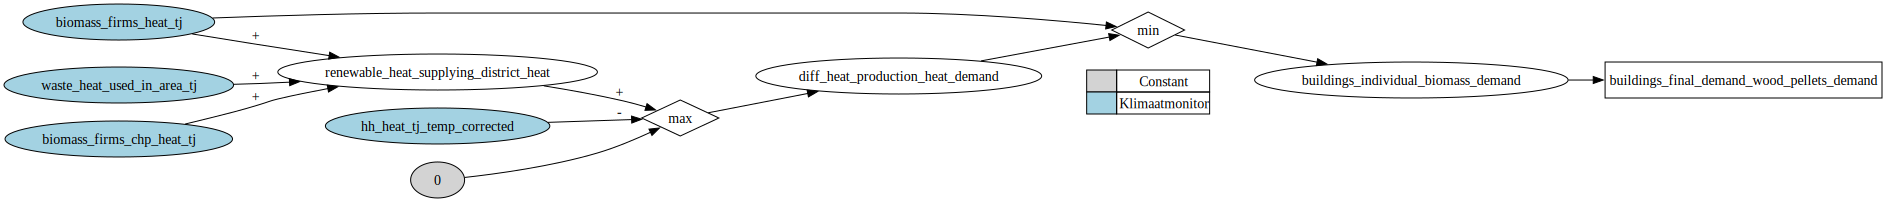

In [15]:
etlocal_key = 'buildings_final_demand_wood_pellets_demand'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read information for the commit message

In [16]:
sector = 'buildings'
output_description = 'Final biomass demand'
arithmic_op= 'add'
vars_description = ['total biomass demand in ', 'total gas demand in commercial buildings']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']


message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)


Final biomass demand in the buildings sector is calculated by adding total biomass demand in  (Klimaatmonitor, 2023) by the total gas demand in commercial buildings (Klimaatmonitor, 2023).


2. Calculate etlocal_key values

In [17]:
ivar = 'buildings_individual_biomass_demand'

df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,buildings_final_demand_wood_pellets_demand,renewable_heat_supplying_district_heat,diff_heat_production_heat_demand,buildings_individual_biomass_demand,error_message,commit
GM0014,0.0,7.0,0.0,0.0,NaN,Final biomass demand in the buildings sector i...
GM0034,0.0,27.0,0.0,0.0,NaN,Final biomass demand in the buildings sector i...
GM0037,0.0,15.0,14.0,0.0,NaN,Final biomass demand in the buildings sector i...
GM0047,0.0,0.0,0.0,0.0,NaN,Final biomass demand in the buildings sector i...
GM0050,0.0,6.0,0.0,0.0,NaN,Final biomass demand in the buildings sector i...
...,...,...,...,...,...,...
GM1979,1.0,3982.0,3982.0,1.0,NaN,Final biomass demand in the buildings sector i...
GM1980,0.0,0.0,0.0,0.0,NaN,Final biomass demand in the buildings sector i...
GM1982,16.0,331.0,327.0,16.0,NaN,Final biomass demand in the buildings sector i...
GM1991,62.0,70.0,70.0,62.0,NaN,Final biomass demand in the buildings sector i...


3. Add data to template

In [18]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
GM0034,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
GM0037,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
GM0047,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
GM0050,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
...,...,...,...,...,...
GM1979,buildings,buildings_energy_demand,TJ,1.0,Final biomass demand in the buildings sector i...
GM1980,buildings,buildings_energy_demand,TJ,0.0,Final biomass demand in the buildings sector i...
GM1982,buildings,buildings_energy_demand,TJ,16.0,Final biomass demand in the buildings sector i...


4. Use validation function to quick-scan data

In [19]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'buildings_final_demand_wood_pellets_demand',
 'total_rows': 342,
 'zero_count': 196,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 683.0,
 'mean_value': 20.25438596491228,
 'median_value': 0.0}

In [20]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: buildings_final_demand_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 192 municipalities (56.8%)
  large_diff: 128 municipalities (37.9%)
  small_diff: 17 municipalities (5.0%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=683.00, Mean=20.26
  Verification: Min=0.00, Max=1068.00, Mean=29.48
  Abs diff:     Min=0.00, Max=762.00, Mean=25.62

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1859: Template=306

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1859,306.0,1068,762.0,-71.348315,large_diff
GM0439,0.0,730,730.0,-100.000000,large_diff
GM0344,683.0,0,683.0,0.000000,small_diff
GM1960,161.0,563,402.0,-71.403197,large_diff
GM0848,226.0,604,378.0,-62.582781,large_diff
...,...,...,...,...,...
GM0770,0.0,0,0.0,0.000000,exact_match
GM0415,0.0,0,0.0,0.000000,exact_match
GM0777,0.0,0,0.0,0.000000,exact_match
GM0779,0.0,0,0.0,0.000000,exact_match


##### Electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

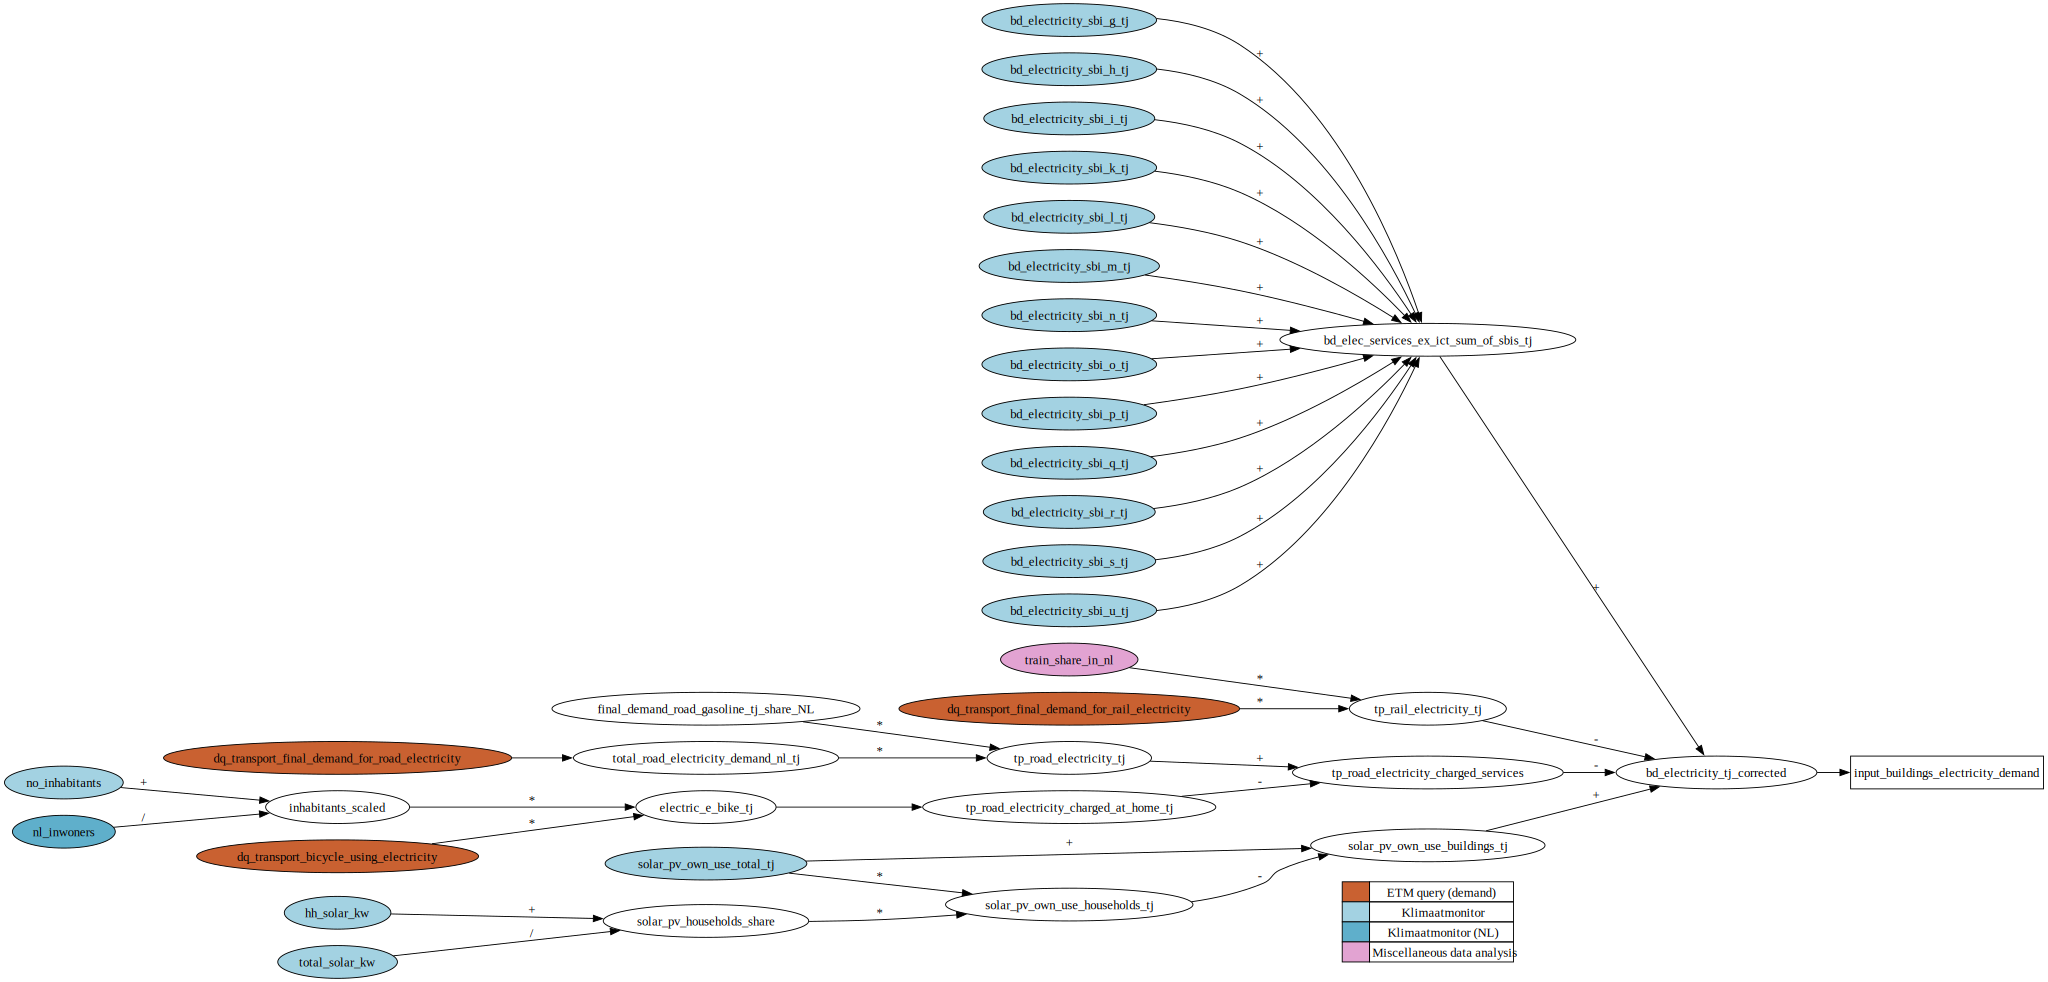

In [21]:
etlocal_key = 'input_buildings_electricity_demand'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read the information for the commit message from the image and write them down to generate the commit message.

In [22]:
# sector = 'buildings'
# output_description = 'Final electricity demand'
# arithmic_op= ['add','add','add','subtract']
# vars_description = ['total electricity demand in utility buildings', 'total solar electricity demand in households', 'total electricity demand in transport sector', 'total electricity demand trains']
# vars_source = ['Klimaatmonitor', 'Klimaatmonitor','Klimaatmonitor and transport research', 'Quintel']


# message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
# print(message)

message = """Final electricity demand in the buildings sector is based on corrected building electricity demand. The total electricity consumption of public and commercial buildings is corrected by subtracting three components: \
1. electricity used by ICT services (SBI J), \
2. electricity used by rail \
3. electricity used by electric vehicles in the transport sector, minus the at-home charging of e-bikes. \
Finally, the behind-the-meter solar electricity consumption generated by rooftop solar panels is added. \
This provides the net electricity demand specifically attributable to buildings after removing transport-related consumption and accounting for \
on-site solar generation. \
  """

message

'Final electricity demand in the buildings sector is based on corrected building electricity demand. The total electricity consumption of public and commercial buildings is corrected by subtracting three components: 1. electricity used by ICT services (SBI J), 2. electricity used by rail 3. electricity used by electric vehicles in the transport sector, minus the at-home charging of e-bikes. Finally, the behind-the-meter solar electricity consumption generated by rooftop solar panels is added. This provides the net electricity demand specifically attributable to buildings after removing transport-related consumption and accounting for on-site solar generation.   '

2. Calculate etlocal_key values


In [23]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,input_buildings_electricity_demand,bd_elec_services_ex_ict_sum_of_sbis_tj,tp_rail_electricity_tj,tp_road_electricity_tj,inhabitants_scaled,electric_e_bike_tj,tp_road_electricity_charged_services,solar_pv_households_share,solar_pv_own_use_households_tj,solar_pv_own_use_buildings_tj,bd_electricity_tj_corrected,error_message,commit
GM0014,1622.738402,1656.7236,51.716995,79.632821,0.013371,0.101156,79.531666,0.481427,90.296537,97.263463,1622.738402,NaN,Final electricity demand in the buildings sect...
GM0034,907.321649,1002.4020,114.937803,73.554183,0.012510,0.094647,73.459535,0.505317,95.323012,93.316988,907.321649,NaN,Final electricity demand in the buildings sect...
GM0037,172.865264,122.6628,0.000000,9.688737,0.001804,0.013650,9.675087,0.133716,9.242448,59.877552,172.865264,NaN,Final electricity demand in the buildings sect...
GM0047,128.234416,104.3604,0.000000,10.893551,0.001550,0.011730,10.881821,0.343238,18.164163,34.755837,128.234416,NaN,Final electricity demand in the buildings sect...
GM0050,274.483883,252.1584,0.000000,27.918477,0.001330,0.010063,27.908413,0.159406,9.526104,50.233896,274.483883,NaN,Final electricity demand in the buildings sect...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1979,209.410880,171.6876,9.043485,16.326404,0.002549,0.019282,16.307123,0.273007,23.686112,63.073888,209.410880,NaN,Final electricity demand in the buildings sect...
GM1980,338.817388,319.1400,9.246527,27.205512,0.004996,0.037797,27.167715,0.552270,69.188371,56.091629,338.817388,NaN,Final electricity demand in the buildings sect...
GM1982,514.171238,482.9580,16.847255,58.638779,0.005133,0.038833,58.599946,0.431326,80.899561,106.660439,514.171238,NaN,Final electricity demand in the buildings sect...
GM1991,389.748440,363.7872,0.000000,34.509142,0.003309,0.025033,34.484109,0.473656,54.394651,60.445349,389.748440,NaN,Final electricity demand in the buildings sect...


3. Add data to template

In [24]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_energy_demand,TJ,1622.738402,Final electricity demand in the buildings sect...
GM0034,buildings,buildings_energy_demand,TJ,907.321649,Final electricity demand in the buildings sect...
GM0037,buildings,buildings_energy_demand,TJ,172.865264,Final electricity demand in the buildings sect...
GM0047,buildings,buildings_energy_demand,TJ,128.234416,Final electricity demand in the buildings sect...
GM0050,buildings,buildings_energy_demand,TJ,274.483883,Final electricity demand in the buildings sect...
...,...,...,...,...,...
GM1979,buildings,buildings_energy_demand,TJ,209.410880,Final electricity demand in the buildings sect...
GM1980,buildings,buildings_energy_demand,TJ,338.817388,Final electricity demand in the buildings sect...
GM1982,buildings,buildings_energy_demand,TJ,514.171238,Final electricity demand in the buildings sect...


4. Use validation function to quick-scan data

In [25]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_buildings_electricity_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 3.6060629266110693,
 'max_value': 7894.878337499988,
 'mean_value': 306.90345682579175,
 'median_value': 156.94271566315626}

In [26]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_buildings_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 165 municipalities (48.8%)
  medium_diff: 155 municipalities (45.9%)
  small_diff: 18 municipalities (5.3%)

 VALUE STATISTICS:
  Template:     Min=3.61, Max=7894.88, Mean=306.08
  Verification: Min=4.70, Max=7617.04, Mean=326.45
  Abs diff:     Min=0.18, Max=1601.03, Mean=39.74

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1966: Template=545.30, Verification=2146.33, Diff=1601.03 (-7

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1966,545.298362,2146.332003,1601.033641,-74.593942,large_diff
GM0363,6988.009734,7463.226439,475.216705,-6.367443,medium_diff
GM1969,210.538873,665.060677,454.521804,-68.342908,large_diff
GM0361,526.703735,876.649571,349.945836,-39.918554,large_diff
GM0394,3968.956023,3628.91451,340.041513,9.370337,medium_diff
...,...,...,...,...,...
GM1978,159.956777,159.371361,0.585417,0.367329,small_diff
GM0353,102.393804,102.788744,0.39494,-0.384225,small_diff
GM0762,162.420744,162.063029,0.357715,0.220726,small_diff
GM0088,15.719405,15.363052,0.356353,2.319544,medium_diff


In [27]:
# View data for municipality GM0453
df_pipeline.loc['GM0453']

input_buildings_electricity_demand                                               449.259237
bd_elec_services_ex_ict_sum_of_sbis_tj                                             462.0672
tp_rail_electricity_tj                                                              5.87134
tp_road_electricity_tj                                                            26.058835
inhabitants_scaled                                                                 0.003862
electric_e_bike_tj                                                                 0.029219
tp_road_electricity_charged_services                                              26.029616
solar_pv_households_share                                                          0.561685
solar_pv_own_use_households_tj                                                    24.467007
solar_pv_own_use_buildings_tj                                                     19.092993
bd_electricity_tj_corrected                                                     

In [28]:
# View data for municipality GM1966
df_pipeline.loc['GM1966']

input_buildings_electricity_demand                                               545.298362
bd_elec_services_ex_ict_sum_of_sbis_tj                                             500.9688
tp_rail_electricity_tj                                                            14.248389
tp_road_electricity_tj                                                            17.971299
inhabitants_scaled                                                                 0.002712
electric_e_bike_tj                                                                 0.020515
tp_road_electricity_charged_services                                              17.950784
solar_pv_households_share                                                          0.286645
solar_pv_own_use_households_tj                                                    30.751265
solar_pv_own_use_buildings_tj                                                     76.528735
bd_electricity_tj_corrected                                                     

### Steam hot water

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

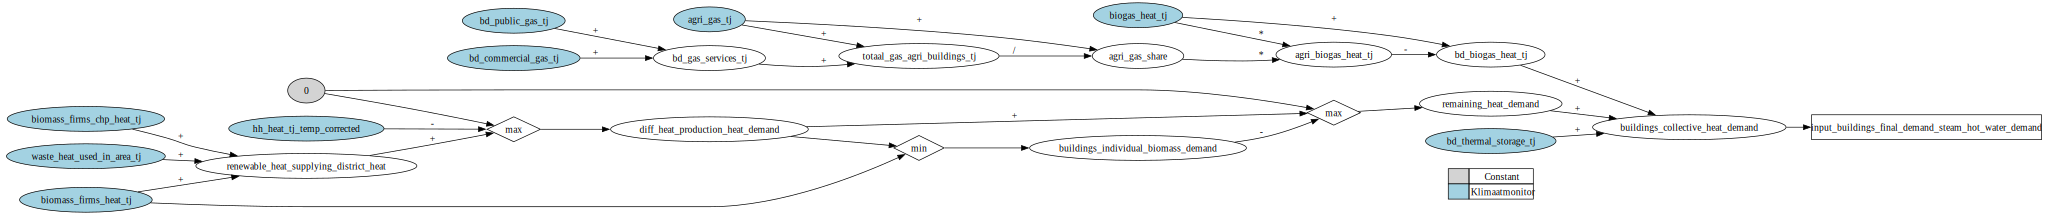

In [29]:
# Define ETLocal key
etlocal_key = "input_buildings_final_demand_steam_hot_water_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

Read the information for the commit message from the image and write them down to generate the commit message.

In [30]:
# sector = 'buildings'
# output_description = 'Final heat demand'
# arithmic_op= 'add'
# vars_description = ['total gas demand in public buildings', 'total gas demand in commercial buildings']
# vars_source = ['Klimaatmonitor', 'Klimaatmonitor']


# message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
# print(message)
# message = """The steam and hot water demand for buildings is calculated\
# as the sum of three components: biogas heat from \
# non-agricultural sources, remaining heat demand from \
# district heating systems, and thermal storage from shallow \
# geothermal systems. The biogas component is derived by \
# subtracting agricultural biogas usage from total biogas heat \
# production, while remaining heat demand represents surplus \
# capacity from renewable district heating after accounting \
# for household consumption.""" 
message = "The steam and hot water demand for buildings is calculated as the sum of three components: biogas heat from non-agricultural sources, remaining heat demand from district heating systems, and thermal storage from shallow geothermal systems. The biogas component is derived by subtracting agricultural biogas usage from total biogas heat production, while remaining heat demand represents surplus capacity from renewable district heating after accounting for household consumption. All data is derived from Klimaatmonitor (2023)."
message

'The steam and hot water demand for buildings is calculated as the sum of three components: biogas heat from non-agricultural sources, remaining heat demand from district heating systems, and thermal storage from shallow geothermal systems. The biogas component is derived by subtracting agricultural biogas usage from total biogas heat production, while remaining heat demand represents surplus capacity from renewable district heating after accounting for household consumption. All data is derived from Klimaatmonitor (2023).'

2. Calculate etlocal_key values

In [31]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,input_buildings_final_demand_steam_hot_water_demand,bd_gas_services_tj,totaal_gas_agri_buildings_tj,agri_gas_share,agri_biogas_heat_tj,bd_biogas_heat_tj,renewable_heat_supplying_district_heat,diff_heat_production_heat_demand,buildings_individual_biomass_demand,remaining_heat_demand,buildings_collective_heat_demand,error_message,commit
GM0014,194.157993,1574.290212,1600.717962,0.016510,0.842007,50.157993,7.0,0.0,0.0,0.0,194.157993,NaN,The steam and hot water demand for buildings i...
GM0034,342.000000,244.512771,567.121221,0.568853,0.000000,0.000000,27.0,0.0,0.0,0.0,342.000000,NaN,The steam and hot water demand for buildings i...
GM0037,15.000000,147.978341,159.467291,0.072046,0.000000,0.000000,15.0,14.0,0.0,14.0,15.000000,NaN,The steam and hot water demand for buildings i...
GM0047,7.620799,142.571919,150.737619,0.054172,0.379201,6.620799,0.0,0.0,0.0,0.0,7.620799,NaN,The steam and hot water demand for buildings i...
GM0050,4.000000,188.402354,408.021704,0.538254,0.000000,0.000000,6.0,0.0,0.0,0.0,4.000000,NaN,The steam and hot water demand for buildings i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1979,3984.000000,277.920296,317.767646,0.125398,0.000000,0.000000,3982.0,3982.0,1.0,3981.0,3984.000000,NaN,The steam and hot water demand for buildings i...
GM1980,19.000000,229.665123,1014.268623,0.773566,0.000000,0.000000,0.0,0.0,0.0,0.0,19.000000,NaN,The steam and hot water demand for buildings i...
GM1982,337.344878,408.633150,945.796950,0.567948,9.655122,7.344878,331.0,327.0,16.0,311.0,337.344878,NaN,The steam and hot water demand for buildings i...
GM1991,16.000000,340.870500,409.107900,0.166796,0.000000,0.000000,70.0,70.0,62.0,8.0,16.000000,NaN,The steam and hot water demand for buildings i...


3. Add data to template

In [32]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_energy_demand,TJ,194.157993,The steam and hot water demand for buildings i...
GM0034,buildings,buildings_energy_demand,TJ,342.000000,The steam and hot water demand for buildings i...
GM0037,buildings,buildings_energy_demand,TJ,15.000000,The steam and hot water demand for buildings i...
GM0047,buildings,buildings_energy_demand,TJ,7.620799,The steam and hot water demand for buildings i...
GM0050,buildings,buildings_energy_demand,TJ,4.000000,The steam and hot water demand for buildings i...
...,...,...,...,...,...
GM1979,buildings,buildings_energy_demand,TJ,3984.000000,The steam and hot water demand for buildings i...
GM1980,buildings,buildings_energy_demand,TJ,19.000000,The steam and hot water demand for buildings i...
GM1982,buildings,buildings_energy_demand,TJ,337.344878,The steam and hot water demand for buildings i...


4. Use validation function to quick-scan data.

In [33]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_buildings_final_demand_steam_hot_water_demand',
 'total_rows': 342,
 'zero_count': 66,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 3984.0,
 'mean_value': 80.46527634727732,
 'median_value': 6.0}

In [34]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_buildings_final_demand_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 236 municipalities (69.8%)
  exact_match: 79 municipalities (23.4%)
  small_diff: 12 municipalities (3.6%)
  medium_diff: 11 municipalities (3.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=3984.00, Mean=80.27
  Verification: Min=0.00, Max=4288.00, Mean=80.29
  Abs diff:     Min=0.00, Max=1512.00, Mean=31.36

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0505: T

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0505,116.000000,1628,1512.0,-92.874693,large_diff
GM0599,2925.872127,3524.954442,599.082315,-16.995463,large_diff
GM0361,1386.739531,864.727314,522.012217,60.367264,large_diff
GM1911,504.371775,42,462.371775,1100.885179,large_diff
GM0164,2116.164838,2513.747603,397.582765,-15.816336,large_diff
...,...,...,...,...,...
GM0589,0.000000,0,0.0,0.000000,exact_match
GM0965,0.000000,0,0.0,0.000000,exact_match
GM0946,1.000000,1,0.0,0.000000,exact_match
GM0944,0.000000,0,0.0,0.000000,exact_match


### Coal demand

 Since there is no coal demand in buildings in the Netherlands, this will be set to zero for all municipalities

In [35]:
# Set coal demand to zero for all municipalities
etlocal_key = 'buildings_final_demand_coal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'buildings_final_demand_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


### Oil demand

 Since there is no coal demand in buildings in the Netherlands, this will be set to zero for all municipalities

In [36]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_buildings_final_demand_crude_oil_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_buildings_final_demand_crude_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


### Solar thermal demand

 Since there is no solar thermal demand registered in buildings in the Netherlands, this will be set to zero for all municipalities

In [37]:
# Set oil demand to zero for all municipalities
etlocal_key = 'buildings_final_demand_solar_thermal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'buildings_final_demand_solar_thermal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


## Energy production

### Solar PV production

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

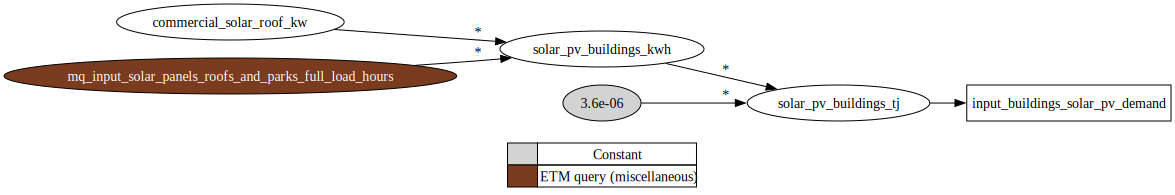

In [38]:
etlocal_key = 'input_buildings_solar_pv_demand'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read information for the commit message

In [39]:
# sector = 'buildings'
# output_description = 'Solar PV production'
# arithmic_op= None
# vars_description = 'registered capacity of solar PV on non-residential buildings'
# vars_source = 'Klimaatmonitor'

# # 
# message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
# print(message)
message = "The solar PV production in the buildings sector is based on the registered capacity of solar PV systems installed on non-residential buildings."
message

'The solar PV production in the buildings sector is based on the registered capacity of solar PV systems installed on non-residential buildings.'

2. Calculate etlocal_key values

In [40]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,input_buildings_solar_pv_demand,solar_pv_buildings_kwh,solar_pv_buildings_tj,error_message,commit
GM0014,411.09084,114191900.0,411.09084,NaN,The solar PV production in the buildings secto...
GM0034,376.57278,104603550.0,376.57278,NaN,The solar PV production in the buildings secto...
GM0037,560.05236,155570100.0,560.05236,NaN,The solar PV production in the buildings secto...
GM0047,152.77140,42436500.0,152.77140,NaN,The solar PV production in the buildings secto...
GM0050,332.99172,92497700.0,332.99172,NaN,The solar PV production in the buildings secto...
...,...,...,...,...,...
GM1979,366.48036,101800100.0,366.48036,NaN,The solar PV production in the buildings secto...
GM1980,182.37492,50659700.0,182.37492,NaN,The solar PV production in the buildings secto...
GM1982,375.97770,104438250.0,375.97770,NaN,The solar PV production in the buildings secto...
GM1991,201.23280,55898000.0,201.23280,NaN,The solar PV production in the buildings secto...


3. Add data to template

In [41]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_energy_supply,TJ,411.09084,The solar PV production in the buildings secto...
GM0034,buildings,buildings_energy_supply,TJ,376.57278,The solar PV production in the buildings secto...
GM0037,buildings,buildings_energy_supply,TJ,560.05236,The solar PV production in the buildings secto...
GM0047,buildings,buildings_energy_supply,TJ,152.77140,The solar PV production in the buildings secto...
GM0050,buildings,buildings_energy_supply,TJ,332.99172,The solar PV production in the buildings secto...
...,...,...,...,...,...
GM1979,buildings,buildings_energy_supply,TJ,366.48036,The solar PV production in the buildings secto...
GM1980,buildings,buildings_energy_supply,TJ,182.37492,The solar PV production in the buildings secto...
GM1982,buildings,buildings_energy_supply,TJ,375.97770,The solar PV production in the buildings secto...


4. Use validation function to quick-scan data

In [42]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_buildings_solar_pv_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 1.82286,
 'max_value': 1055.6685,
 'mean_value': 138.92721,
 'median_value': 82.44423}

In [43]:
verification_results = src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_buildings_solar_pv_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 336 municipalities (99.4%)
  small_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=1.82, Max=1055.67, Mean=137.98
  Verification: Min=0.00, Max=165.84, Mean=22.30
  Abs diff:     Min=1.01, Max=1030.60, Mean=115.69

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1681: Template=1055.67, Verification=25.07, Diff=1030.60 (4110.9%)
  Municipality GM0303: Template=965.20, V

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


## Building stock

### Roof surface area available for PV

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

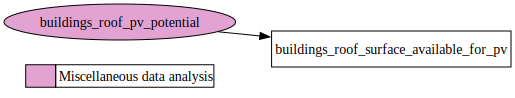

In [45]:
etlocal_key = 'buildings_roof_surface_available_for_pv'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key,
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read information for the commit message

In [46]:
message = "Total roof surface area with ‘functie onbekend, bijeenkomstfunctie, gezondheidszorgfunctie, industriefunctie, kantoorfunctie, logiesfunctie, onderwijsfunctie, overige gebruiksfunctie, sportfunctie, standplaats en winkelfunctie’ according to the BAG (Atlas of the Living Environment, 2021) https://www.atlasleefomgeving.nl/platte-daken-in-nederland-bag."


2. Calculate etlocal_key values

In [47]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


,buildings_roof_surface_available_for_pv,error_message,commit
GM0014,4.680075,NaN,Total roof surface area with ‘functie onbekend...
GM0034,4.066546,NaN,Total roof surface area with ‘functie onbekend...
GM0037,1.151227,NaN,Total roof surface area with ‘functie onbekend...
GM0047,1.323289,NaN,Total roof surface area with ‘functie onbekend...
GM0050,1.802805,NaN,Total roof surface area with ‘functie onbekend...
...,...,...,...
GM1979,2.402362,NaN,Total roof surface area with ‘functie onbekend...
GM1980,3.790870,NaN,Total roof surface area with ‘functie onbekend...
GM1982,6.809434,NaN,Total roof surface area with ‘functie onbekend...
GM1991,3.596529,NaN,Total roof surface area with ‘functie onbekend...


3. Add data to template

In [48]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,buildings,buildings_building_stock,km<sup>2</sup>,4.680075,Total roof surface area with ‘functie onbekend...
GM0034,buildings,buildings_building_stock,km<sup>2</sup>,4.066546,Total roof surface area with ‘functie onbekend...
GM0037,buildings,buildings_building_stock,km<sup>2</sup>,1.151227,Total roof surface area with ‘functie onbekend...
GM0047,buildings,buildings_building_stock,km<sup>2</sup>,1.323289,Total roof surface area with ‘functie onbekend...
GM0050,buildings,buildings_building_stock,km<sup>2</sup>,1.802805,Total roof surface area with ‘functie onbekend...
...,...,...,...,...,...
GM1979,buildings,buildings_building_stock,km<sup>2</sup>,2.402362,Total roof surface area with ‘functie onbekend...
GM1980,buildings,buildings_building_stock,km<sup>2</sup>,3.790870,Total roof surface area with ‘functie onbekend...
GM1982,buildings,buildings_building_stock,km<sup>2</sup>,6.809434,Total roof surface area with ‘functie onbekend...


4. Use validation function to quick-scan data

In [49]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'buildings_roof_surface_available_for_pv',
 'total_rows': 342,
 'zero_count': 1,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 33.151767,
 'mean_value': 2.1019668596491226,
 'median_value': 1.475609}

In [50]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: buildings_roof_surface_available_for_pv
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 334 municipalities (98.8%)
  small_diff: 4 municipalities (1.2%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=33.15, Mean=2.07
  Verification: Min=0.00, Max=33.15, Mean=2.06
  Abs diff:     Min=0.00, Max=2.68, Mean=0.02

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0164: Template=2.68, Verification=0.00, Diff=2.68 (0.0%)
  Municipality GM1970: Template=2.29, Verification=0.

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0164,2.677392,0,2.677392,0.000000e+00,small_diff
GM1970,2.294715,0,2.294715,0.000000e+00,small_diff
GM0820,0.785776,0,0.785776,0.000000e+00,small_diff
GM0299,1.765181,1.765181,0.0,-1.257914e-14,small_diff
GM0858,1.211064,1.211064,0.0,0.000000e+00,exact_match
...,...,...,...,...,...
GM0384,0.457436,0.457436,0.0,0.000000e+00,exact_match
GM0383,0.683617,0.683617,0.0,0.000000e+00,exact_match
GM0377,0.316567,0.316567,0.0,0.000000e+00,exact_match
GM0376,0.138510,0.13851,0.0,0.000000e+00,exact_match


## Export
Write the resulting filled template to a csv

In [51]:
# Write the filled template to a CSV file
path_output = Path("data", "processed", f"etlocal_template_buildings_filled.csv")
df_template_local.to_csv(path_output, sep=sep)
